In [38]:
# Load libraries

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import os
import json
import sys
from datetime import datetime, UTC
import matplotlib.dates as mdates
from matplotlib.dates import MO  # Monday as start of week

# Append utils to path for logo import
sys.path.append("utils")
from logo import add_logo

date = 'April 16th, 2025'


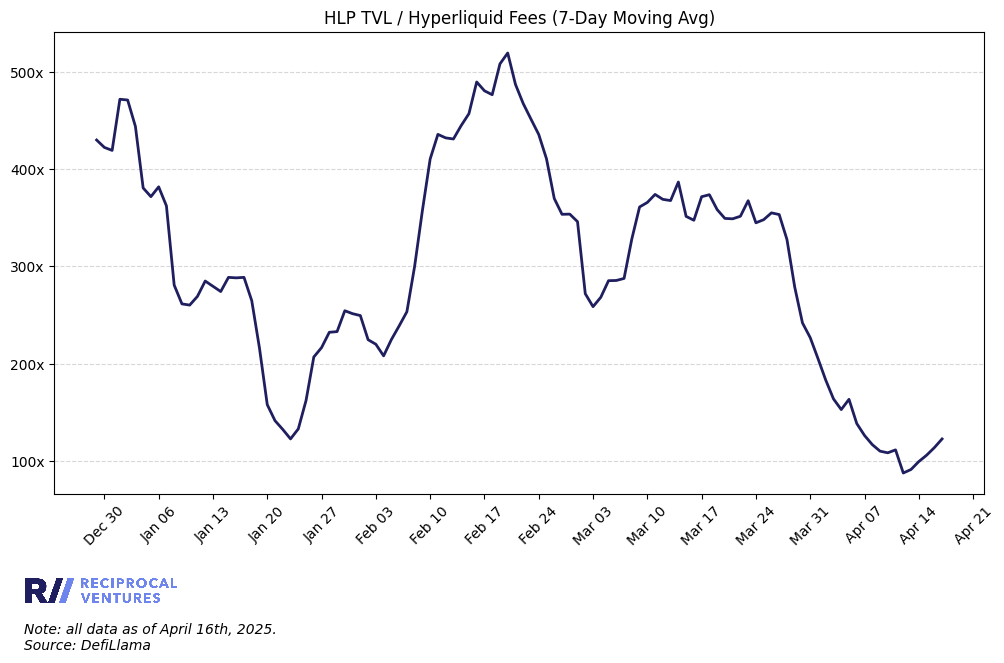

          date           tvl     fees  tvl-to-fees  tvl-to-fees-7d
105 2025-04-08  1.499814e+08  1746313    85.884597      116.903407
106 2025-04-09  1.482302e+08  2837027    52.248431      110.154291
107 2025-04-10  1.498008e+08  1686123    88.843334      108.456529
108 2025-04-11  1.495930e+08  1327396   112.696559      111.473799
109 2025-04-12  1.559157e+08  1164323   133.911057       87.702156
110 2025-04-13  1.576559e+08  1365048   115.494737       91.342665
111 2025-04-14  1.598938e+08  1491560   107.199012       99.468247
112 2025-04-15  1.603078e+08  1221402   131.248983      105.948873
113 2025-04-16  1.612290e+08  1508963   106.847533      113.748745
114 2025-04-17  1.645104e+08  1085608   151.537613      122.705071


In [7]:
# Load Hyperliquid fees data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-fees.json", "r") as f:
    fee_data = json.load(f)

fee_df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp", "fees"])
fee_df["date"] = pd.to_datetime(fee_df["timestamp"], unit="s")
fee_df = fee_df[["date", "fees"]]

# Load HLP TVL data
with open("raw-data/defillama-raw-data/defillama_HLP.json", "r") as f:
    hlp_data = json.load(f)

hlp_raw = hlp_data["chainTvls"]["Hyperliquid"]["tvl"]
hlp_df = pd.DataFrame(hlp_raw)
hlp_df["date"] = pd.to_datetime(hlp_df["date"], unit="s")
hlp_df = hlp_df.rename(columns={"totalLiquidityUSD": "tvl"})
hlp_df = hlp_df[["date", "tvl"]]

# Merge datasets
df = pd.merge(hlp_df, fee_df, on="date", how="inner")
df["tvl-to-fees"] = df["tvl"] / df["fees"]

# Calculate trailing 7-day average
df["tvl-to-fees-7d"] = df["tvl-to-fees"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["tvl-to-fees-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting for weekly ticks
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Y-axis formatting
ax.set_title("HLP TVL / Hyperliquid Fees (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}x'))

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/tvl-to-fees_ratio_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "tvl", "fees", "tvl-to-fees", "tvl-to-fees-7d"]].tail(10))

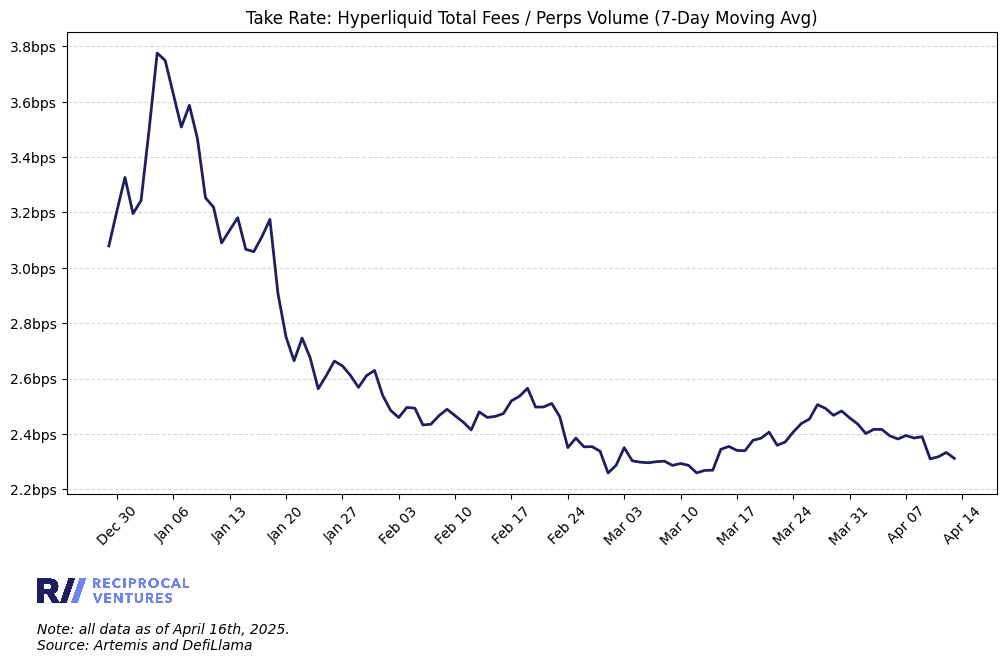

          date     fees  perps-volume  take-rate  take-rate-7d
102 2025-04-05   545156  2.430774e+09   2.242726      2.392919
103 2025-04-06  1772829  7.538398e+09   2.351732      2.381593
104 2025-04-07  3117000  1.330997e+10   2.341853      2.394353
105 2025-04-08  1746313  7.663480e+09   2.278747      2.385129
106 2025-04-09  2837027  1.244462e+10   2.279722      2.389800
107 2025-04-10  1686123  7.229337e+09   2.332334      2.309830
108 2025-04-11  1327396  5.544363e+09   2.394136      2.317321
109 2025-04-12  1164323  4.949383e+09   2.352461      2.332998
110 2025-04-13  1365048  6.199138e+09   2.201996      2.311607
111 2025-04-14  1491560           NaN        NaN           NaN


In [8]:
# Load Hyperliquid fees data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-fees.json", "r") as f:
    fee_data = json.load(f)

fee_df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp", "fees"])
fee_df["date"] = pd.to_datetime(fee_df["timestamp"], unit="s")
fee_df = fee_df[["date", "fees"]]

# Load Hyperliquid perps volume data
volume_df = pd.read_csv('raw-data/artemis-raw-data/artemis_perps-trading-volume.csv')
volume_df['Date'] = pd.to_datetime(volume_df['Date'], format='%d-%b-%y')
volume_df.rename(columns={'Date': 'date', 'Hyperliquid': 'perps-volume'}, inplace=True)

# Merge datasets
df = pd.merge(volume_df, fee_df, on="date", how="inner")
df["take-rate"] = df["fees"] / df["perps-volume"] * 10000  # Convert to BPS

# Calculate trailing 7-day average
df["take-rate-7d"] = df["take-rate"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["take-rate-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Take Rate: Hyperliquid Total Fees / Perps Volume (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}bps'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: Artemis and DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/take-rate_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "fees", "perps-volume", "take-rate", "take-rate-7d"]].tail(10))


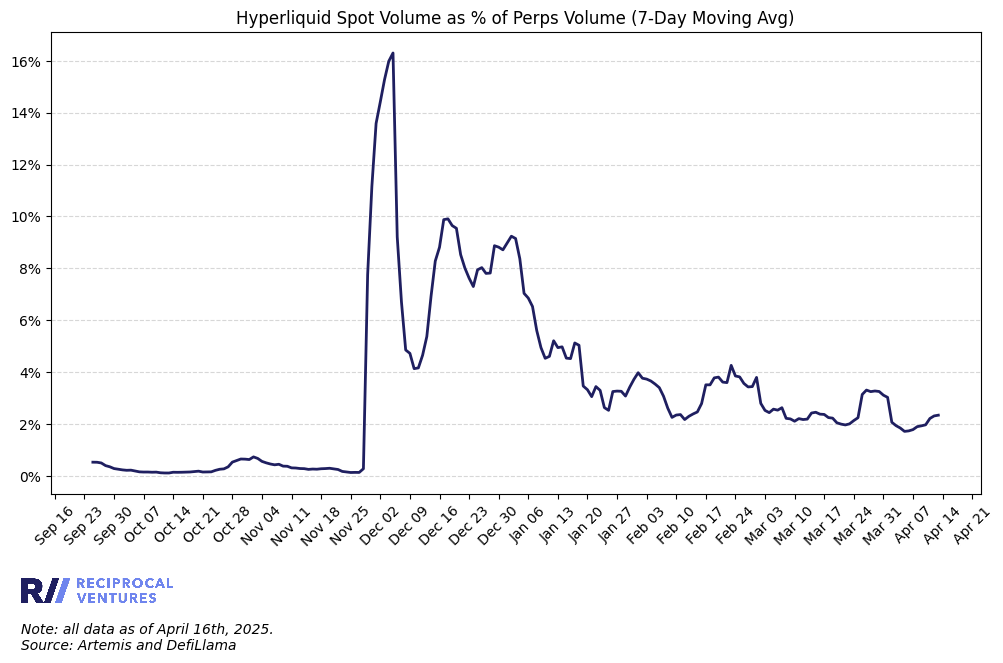

          date  spot-volume  perps-volume  spot-volume-percent-perps-volume  \
198 2025-04-05     42672433  2.430774e+09                          1.755508   
199 2025-04-06    148050393  7.538398e+09                          1.963950   
200 2025-04-07    254918742  1.330997e+10                          1.915246   
201 2025-04-08    163870707  7.663480e+09                          2.138333   
202 2025-04-09    256513559  1.244462e+10                          2.061241   
203 2025-04-10    165359677  7.229337e+09                          2.287342   
204 2025-04-11    187070232  5.544363e+09                          3.374062   
205 2025-04-12    121367900  4.949383e+09                          2.452183   
206 2025-04-13    134246965  6.199138e+09                          2.165575   
207 2025-04-14    126974634           NaN                               NaN   

     spot-volume-percent-perps-volume-7d  
198                             1.717844  
199                             1.736498  
2

In [9]:
# Load Hyperliquid spot volume data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-spot-volumes.json", "r") as f:
    spot_volume_data = json.load(f)

spot_volume_df = pd.DataFrame(spot_volume_data["totalDataChart"], columns=["timestamp", "spot-volume"])
spot_volume_df["date"] = pd.to_datetime(spot_volume_df["timestamp"], unit="s")
spot_volume_df = spot_volume_df[["date", "spot-volume"]]

# Load Hyperliquid perps volume data
perps_volume_df = pd.read_csv('raw-data/artemis-raw-data/artemis_perps-trading-volume.csv')
perps_volume_df['Date'] = pd.to_datetime(perps_volume_df['Date'], format='%d-%b-%y')
perps_volume_df.rename(columns={'Date': 'date', 'Hyperliquid': 'perps-volume'}, inplace=True)

# Merge datasets
df = pd.merge(perps_volume_df, spot_volume_df, on="date", how="inner")
df["spot-volume-percent-perps-volume"] = df["spot-volume"] / df["perps-volume"] * 100 # convert to %

# Calculate trailing 7-day average
df["spot-volume-percent-perps-volume-7d"] = df["spot-volume-percent-perps-volume"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["spot-volume-percent-perps-volume-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Hyperliquid Spot Volume as % of Perps Volume (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: Artemis and DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/spot-volume-percent-perps-volume_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "spot-volume", "perps-volume", "spot-volume-percent-perps-volume", "spot-volume-percent-perps-volume-7d"]].tail(10))


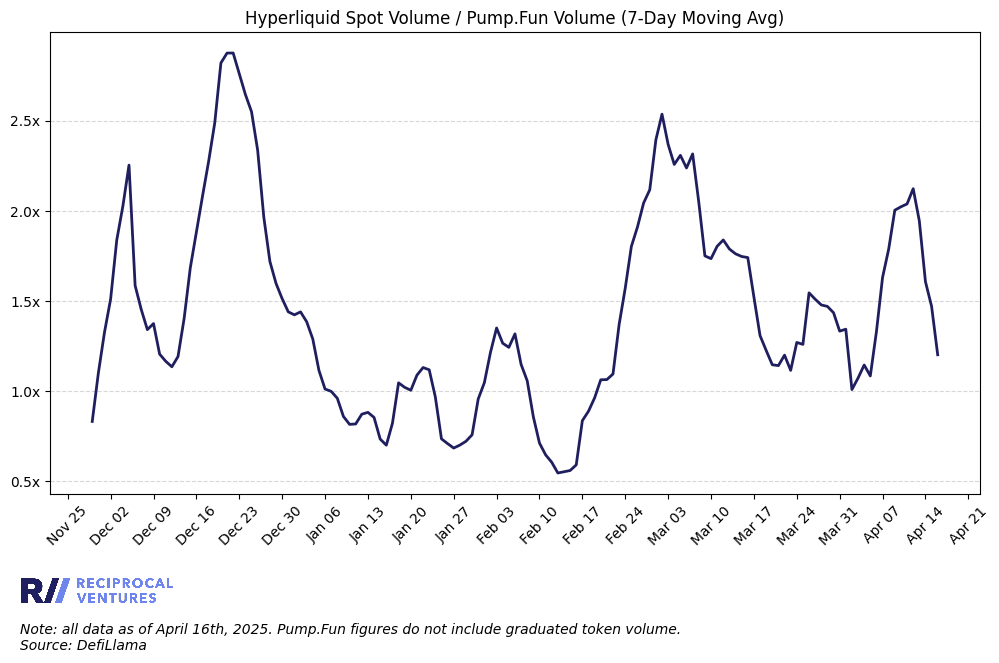

          date  hyperliquid-spot-volume  hyperliquid-spot-volume  \
135 2025-04-07                254918742                254918742   
136 2025-04-08                163870707                163870707   
137 2025-04-09                256513559                256513559   
138 2025-04-10                165359677                165359677   
139 2025-04-11                187070232                187070232   
140 2025-04-12                121367900                121367900   
141 2025-04-13                134246965                134246965   
142 2025-04-14                126974634                126974634   
143 2025-04-15                120978471                120978471   
144 2025-04-16                155624952                155624952   

     hyperliquid-memecoin-market-share  hyperliquid-memecoin-market-share-7d  
135                           3.323031                              1.630634  
136                           1.860535                              1.787698  
137           

In [10]:
# Load Hyperliquid spot volume data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-spot-volumes.json", "r") as f:
    hyperliquid_spot_volume_data = json.load(f)

hyperliquid_spot_volume_df = pd.DataFrame(hyperliquid_spot_volume_data["totalDataChart"], columns=["timestamp", "hyperliquid-spot-volume"])
hyperliquid_spot_volume_df["date"] = pd.to_datetime(hyperliquid_spot_volume_df["timestamp"], unit="s")
hyperliquid_spot_volume_df = hyperliquid_spot_volume_df[["date", "hyperliquid-spot-volume"]]

# Load Pump.Fun volume data
with open("raw-data/defillama-raw-data/defillama_pumpfun-spot-volumes.json", "r") as f:
    pumpfun_spot_volume_data = json.load(f)

pumpfun_spot_volume_df = pd.DataFrame(pumpfun_spot_volume_data["totalDataChart"], columns=["timestamp", "pumpfun-spot-volume"])
pumpfun_spot_volume_df["date"] = pd.to_datetime(pumpfun_spot_volume_df["timestamp"], unit="s")
pumpfun_spot_volume_df = pumpfun_spot_volume_df[["date", "pumpfun-spot-volume"]]

# Merge datasets
df = pd.merge(hyperliquid_spot_volume_df, pumpfun_spot_volume_df, on="date", how="inner")
df["hyperliquid-memecoin-market-share"] = df["hyperliquid-spot-volume"] / df["pumpfun-spot-volume"]

# Calculate trailing 7-day average
df["hyperliquid-memecoin-market-share-7d"] = df["hyperliquid-memecoin-market-share"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["hyperliquid-memecoin-market-share-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Hyperliquid Spot Volume / Pump.Fun Volume (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}x'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}. Pump.Fun figures do not include graduated token volume.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/hyperliquid-to-pumpfun-volume-ratio_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "hyperliquid-spot-volume", "hyperliquid-spot-volume", "hyperliquid-memecoin-market-share", "hyperliquid-memecoin-market-share-7d"]].tail(10))

In [32]:
# Load Hyperliquid spot stric list volume data

# Map <file‑name slug>  ➜  <clean column prefix>
assets = {
    "purr-2":       "PURR",
    "hypurr-fun":   "HFUN",
    "pip-3":        "PIP",
    "jeff-3":       "JEFF",
    "farm-2":       "FARM",
    "catbal":       "CATBAL",
    "vapor":        "VAPOR",
    "atehun":       "ATEHUN",
}

# For colors
color_palette = {'Hyperliquid':'#09b882', 'Bold Blue':'#1f1f60', 'Sky Blue':'#6f85ee', 'Engage Orange':'#eda024', 'Dark Slate':'#262935', 'Mauve':'#7c1158', 'Yellow':'#ebdc78', 'Green':'#00b7c7', 'Red':'#b30000','Mid Grey':'#54504c','Other Grey':'#a4a2a8', 'Pure Grey': '#808080','Lighter Grey': '#A9A9A9','Lightest Grey': '#D3D3D3','blue 1':'#03045e', 'blue 2':'#0077b6', 'blue 3':'#00b4d8', 'blue 4':'#90e0ef', 'blue 5':'#caf0f8', 'blue 6': '#d9f4fa', 'blue 7': '##f1fcfe'}
asset_colors = {
        'PURR': color_palette['Bold Blue'],     
        'HFUN': color_palette['blue 1'],          
        'PIP': color_palette['blue 2'],
        'JEFF': color_palette['blue 3'],
        'FARM': color_palette['blue 4'],
        'CATBAL': color_palette['blue 5'],
        'VAPOR': color_palette['blue 6'],
        'ATEHUN': color_palette['blue 7'],
        'Other': color_palette['Other Grey']
    }

df_master = None
df_calc = None

for raw_id, asset in assets.items():
    # Load data spot asset data
    path = f"raw-data/coingecko-raw-data/coingecko_{raw_id}_spot_strict_list_data.json"
    with open(path) as f:
        data = json.load(f)

    coin_df = (
        pd.DataFrame(data["total_volumes"], columns=["timestamp", f"{asset}-spot-volume"])
          .assign(date=lambda d: pd.to_datetime(d["timestamp"], unit="ms"))
          .loc[:, ["date", f"{asset}-spot-volume"]]
    )

    # Transform data to 7d avg index
    first_val = coin_df[f"{asset}-spot-volume"].iloc[0]
    coin_df[f"{asset}-indexed-spot-volume"]     = coin_df[f"{asset}-spot-volume"] / first_val * 100
    coin_df[f"{asset}-indexed-spot-volume-7d"]  = coin_df[f"{asset}-indexed-spot-volume"].rolling(7).mean()
    coin_df[f'{asset}-spot-volume-7d'] = coin_df[f'{asset}-spot-volume'].rolling(7).mean()

    # Kill indexed values
    coin_calc_df = coin_df[['date', f'{asset}-spot-volume']]
    coin_df[f'{asset}'] = coin_df[f"{asset}-spot-volume-7d"]
    coin_df = coin_df[["date", f"{asset}"]]
    

    # Merge dataframes
    df_calc = coin_calc_df if df_calc is None else df_calc.merge(coin_calc_df, on='date', how='inner')
    df_master = coin_df if df_master is None else df_master.merge(coin_df, on="date", how="inner")

# Add total spot column
df_calc['sum-volume'] = df_calc.drop(columns=['date']).sum(axis=1)

# Load Hyperliquid spot volume data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-spot-volumes.json", "r") as f:
    hyperliquid_spot_volume_data = json.load(f)

hyperliquid_spot_volume_df = pd.DataFrame(hyperliquid_spot_volume_data["totalDataChart"], columns=["timestamp", "hyperliquid-total-spot-volume"])
hyperliquid_spot_volume_df["date"] = pd.to_datetime(hyperliquid_spot_volume_df["timestamp"], unit="s")
hyperliquid_spot_volume_df = hyperliquid_spot_volume_df[["date", "hyperliquid-total-spot-volume"]]

# Merge dataframes
df_calc = df_calc.merge(hyperliquid_spot_volume_df, on='date', how='inner')
df_calc['other-spot-volume'] = df_calc['hyperliquid-total-spot-volume'] - df_calc['sum-volume']
df_calc['other-spot-volume-7d'] = df_calc['other-spot-volume'].rolling(7).mean()
df_calc['Other'] = df_calc['other-spot-volume-7d']
df_calc = df_calc[['date','Other']]
df_master = df_master.merge(df_calc, on='date', how='inner')


# Extract the color list from the color directory
color_list = [asset_colors[col] for col in df_master.columns if col != 'date']

# Plotting the stacked area chart with custom colors
data.plot(kind='area', stacked=True, ax=ax, color=color_list)

fig, ax = plt.subplots(figsize=(12,8))
for raw_id, asset in assets.items()
        ax.plot(
            df_master['date'], 
            df_master[f"{asset}-indexed-spot-volume-7d"], 
            label=[f"{asset}"], 
            color=platform_colors[asset],
            linewidth=2
        )

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Hyperliquid Select Strict List Spot Volume (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.f}'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}. HYPE, BTC, and ETH not included. Only includes strict list spot tokens tracked by CoinGecko. Includes \nSource: CoinGecko", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/hyperliquid-white-list-spot-volume-index_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()


print(df_master.tail(10))




SyntaxError: expected ':' (3021768637.py, line 87)

In [ ]:
# Extract the color list from the color directory
color_list = [asset_colors[col] for col in df_master.columns if col != 'date']

# Plotting the stacked area chart with custom colors
data.plot(kind='area', stacked=True, ax=ax, color=color_list)

fig, ax = plt.subplots(figsize=(12,8))
for raw_id, asset in assets.items()
        ax.plot(
            df_master['date'], 
            df_master[f"{asset}-indexed-spot-volume-7d"], 
            label=[f"{asset}"], 
            color=platform_colors[asset],
            linewidth=2
        )

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Hyperliquid White List Spot Volume (Indexed to Jan 1, 7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.f}'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}. HYPE, BTC, and ETH not included. Only includes strict list spot tokens tracked by CoinGecko. Includes \nSource: CoinGecko", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/hyperliquid-white-list-spot-volume-index_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()


print(df_master.tail(10))

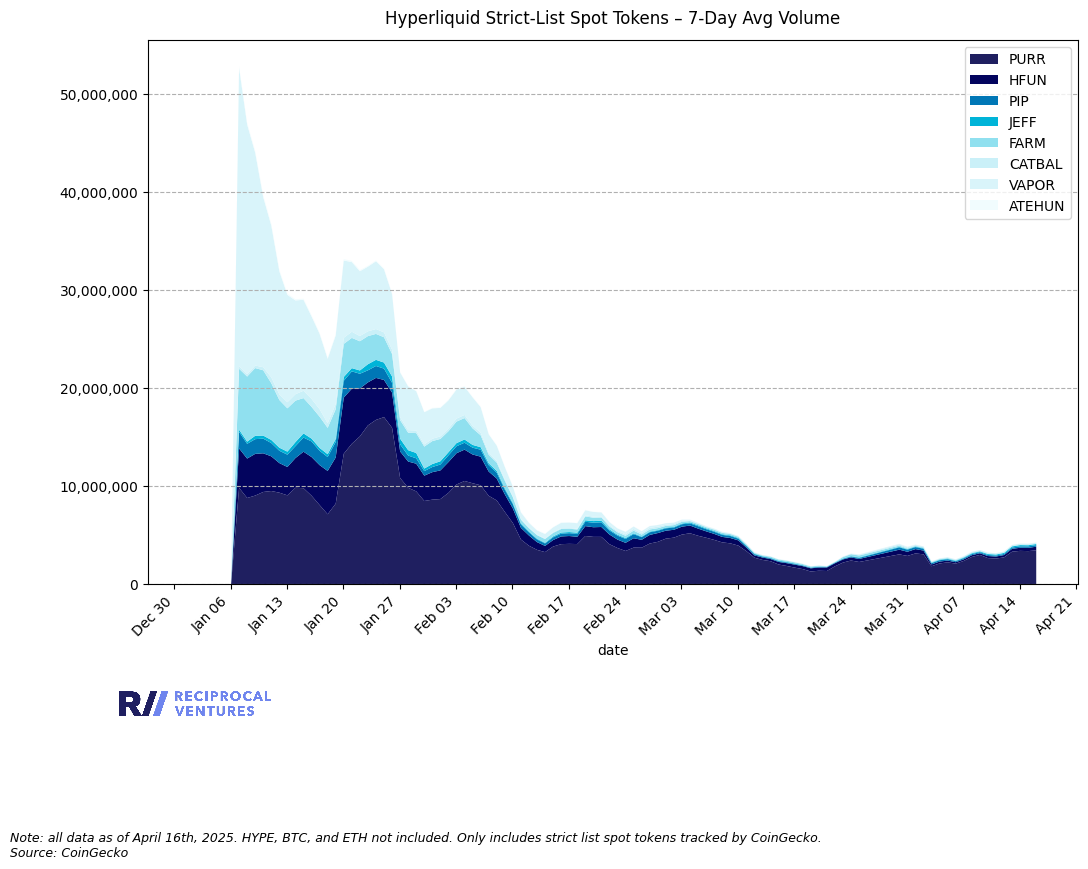

          date          PURR           HFUN            PIP           JEFF  \
92  2025-04-07  2.405979e+06  162451.554080  113867.749777   59600.715808   
93  2025-04-08  2.810942e+06  180560.949661  110657.120576   77332.500214   
94  2025-04-09  3.014886e+06  172953.684032  107375.789027   77805.889208   
95  2025-04-10  2.694922e+06  209712.810408  105513.700125   93077.586214   
96  2025-04-11  2.646861e+06  205619.376749  100510.608357   99878.436475   
97  2025-04-12  2.764955e+06  239145.312555  110237.883698  106635.349873   
98  2025-04-13  3.347120e+06  291823.728639  128483.108380  116344.745630   
99  2025-04-14  3.432217e+06  313554.076627  145351.919876  125977.477061   
100 2025-04-15  3.406030e+06  333344.745679  146886.707575  116047.311847   
101 2025-04-16  3.487877e+06  366291.579044  161464.742238  112454.630155   

             FARM         CATBAL         VAPOR       ATEHUN         Other  
92   69706.845573   62525.286176  12291.333340  4233.234083  1.272562e+08  


In [45]:
# Hyperliquid spot‑volume – 7‑day moving‑average stacked area chart
# -----------------------------------------------------------------
import json, os, sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from datetime import datetime
from matplotlib.dates import MO  # Monday

# -------------------------------------------------- colour palette
color_palette = {
    'Bold Blue':'#1f1f60', 'Sky Blue':'#6f85ee',
    'blue 1':'#03045e', 'blue 2':'#0077b6',
    'blue 3':'#00b4d8', 'blue 4':'#90e0ef',
    'blue 5':'#caf0f8', 'blue 6':'#d9f4fa', 'blue 7': '#f1fcfe',
}

asset_colors = {
    'PURR':  color_palette['Bold Blue'],
    'HFUN':  color_palette['blue 1'],
    'PIP':   color_palette['blue 2'],
    'JEFF':  color_palette['blue 3'],
    'FARM':  color_palette['blue 4'],
    'CATBAL':color_palette['blue 5'],
    'VAPOR': color_palette['blue 6'],
    'ATEHUN':color_palette['blue 7'],   
}

# -------------------------------------------------- asset map
assets = {
    "purr-2":     "PURR",
    "hypurr-fun": "HFUN",
    "pip-3":      "PIP",
    "jeff-3":     "JEFF",
    "farm-2":     "FARM",
    "catbal":     "CATBAL",
    "vapor":      "VAPOR",
    "atehun":     "ATEHUN",
}

# -------------------------------------------------- build df_master
df_master, df_calc = None, None

for slug, label in assets.items():
    path = f"raw-data/coingecko-raw-data/coingecko_{slug}_spot_strict_list_data.json"
    with open(path) as f:
        data = json.load(f)

    coin_df = (
        pd.DataFrame(data["total_volumes"],
                     columns=["timestamp", f"{label}-spot-volume"])
          .assign(date=lambda d: pd.to_datetime(d["timestamp"], unit="ms"))
          .loc[:, ["date", f"{label}-spot-volume"]]
    )

    coin_df[f"{label}-spot-volume-7d"] = coin_df[f"{label}-spot-volume"].rolling(7).mean()

    coin_calc_df = coin_df[["date", f"{label}-spot-volume"]]
    coin_area_df = coin_df.rename(columns={f"{label}-spot-volume-7d": label})[["date", label]]

    df_calc   = coin_calc_df if df_calc   is None else df_calc.merge(coin_calc_df, on="date", how="inner")
    df_master = coin_area_df if df_master is None else df_master.merge(coin_area_df, on="date", how="inner")

# ---------- (optional) compute “Other” but do not plot ----------
with open("raw-data/defillama-raw-data/defillama_hyperliquid-spot-volumes.json") as f:
    hl_raw = json.load(f)

hl_df = (pd.DataFrame(hl_raw["totalDataChart"],
                      columns=["timestamp", "hyperliquid-total-spot-volume"])
           .assign(date=lambda d: pd.to_datetime(d["timestamp"], unit="s"))
           .loc[:, ["date", "hyperliquid-total-spot-volume"]])

df_calc = df_calc.merge(hl_df, on="date", how="inner")
df_calc["Other"] = (
    df_calc["hyperliquid-total-spot-volume"]
    - df_calc.drop(columns=["date", "hyperliquid-total-spot-volume"]).sum(axis=1)
).rolling(7).mean()

df_master = df_master.merge(df_calc[["date", "Other"]], on="date", how="inner")
df_master = df_master.sort_values("date").reset_index(drop=True)

# -------------------------------------------------- plot
plt.style.use("default")
fig, ax = plt.subplots(figsize=(12, 8))

plot_cols = [c for c in df_master.columns if c not in ("date", "Other")]

df_master.set_index("date")[plot_cols].plot.area(
    ax=ax,
    stacked=True,
    linewidth=0,
    color=[asset_colors[c] for c in plot_cols]
)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

ax.set_title("Hyperliquid Strict‑List Spot Tokens – 7‑Day Avg Volume", pad=12)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.grid(axis='y', linestyle='--', alpha=1)

sys.path.append("utils")
from logo import add_logo
add_logo(ax, position=(0.05, -0.22))

today_str = datetime.now(UTC).strftime("%d %b %Y")
plt.figtext(0.01, -0.14,
            f"Note: all data as of {date}. HYPE, BTC, and ETH not included. Only includes strict list spot tokens tracked by CoinGecko.\nSource: CoinGecko",
            ha="left", fontsize=9, style="italic")

os.makedirs("plots", exist_ok=True)
plt.savefig("plots/hyperliquid_strict_list_spot_volume_7d_area.png",
            dpi=300, bbox_inches="tight")
plt.show()

print(df_master.tail(10))
